In [33]:
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from rae import PROJECT_ROOT


In [34]:
def encoder_factory(encoder_type, num_layers: int, in_channels: int, out_channels: int, **params):
    assert num_layers > 0
    if encoder_type == "GCN2Conv":
        convs = []
        for layer in range(num_layers):
            convs.append(GCN2Conv(layer=layer + 1, channels=out_channels, **params))
        return nn.ModuleList(convs)

    elif encoder_type == "GCNConv":
        convs = []
        convs = [
            GCNConv(
                in_channels=in_channels,
                out_channels=out_channels,
                **params,
            )
        ]
        in_channels = out_channels
        for layer in range(num_layers - 1):
            convs.append(
                GCNConv(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    **params,
                )
            )
        return nn.ModuleList(convs)

    elif encoder_type == "GATConv":
        convs = []     
        convs = [
            GATConv(
                in_channels=in_channels,
                out_channels=out_channels,
                **params,
            )
        ]
        in_channels = out_channels
        for layer in range(num_layers - 1):
            convs.append(
                GATConv(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    **params,
                )
            )

        return nn.ModuleList(convs)

    elif encoder_type == "GINConv":
        convs = []
        current_in_channels = in_channels
        for layer in range(num_layers):
            convs.append(
                GINConv(
                    nn=nn.Linear(
                        in_features=current_in_channels,
                        out_features=out_channels,
                    ),
                    **params,
                )
            )
            current_in_channels = out_channels
        return nn.ModuleList(convs)

    else:
        raise NotImplementedError

In [35]:
experiments = torch.load(PROJECT_ROOT / "experiments" / "sec:data-manifold" / f"{'Cora'}_data_manifold_experiments.pt")
len(experiments)

1920

In [36]:
stats = pd.read_csv(PROJECT_ROOT / "experiments" / "sec:data-manifold" / f"{'Cora'}_data_manifold_stats.pt", sep="\t", index_col=0)
stats

,experiment,epoch,loss,train_acc,val_acc,reference_distance
0,0,0,1.958628,0.153057,0.166052,0.071401
1,0,1,1.906447,0.299138,0.328413,0.096971
2,0,2,1.869278,0.299138,0.328413,0.072156
3,0,3,1.846171,0.299138,0.328413,0.076211
4,0,4,1.835588,0.299138,0.328413,0.093176
...,...,...,...,...,...,...
57595,1919,45,1.910669,0.299138,0.328413,0.079737
57596,1919,46,1.909050,0.299138,0.328413,0.077889
57597,1919,47,1.908956,0.299138,0.328413,0.076298
57598,1919,48,1.907391,0.299138,0.328413,0.081818


In [37]:
best_run = torch.load(PROJECT_ROOT / "experiments" / "sec:data-manifold" / f"{'Cora'}_best_run.pt")
best_run_latents = [best_run['best_epoch']['rel_x']]
best_run

{'conv_fn': ReLU(),
 'dropout': 0.5,
 'encoder': ('GCN2Conv',
  functools.partial(<function encoder_factory at 0x7f08e6cc33a0>, encoder_type='GCN2Conv', alpha=0.1, theta=0.5, shared_weights=True, normalize=False)),
 'hidden_fn': ReLU(),
 'in_channels': 300,
 'lr': 0.02,
 'num_epochs': 500,
 'num_layers': 32,
 'optimizer': torch.optim.adam.Adam,
 'out_channels': 300,
 'seed': 1,
 'best_epoch': {'rel_x': tensor([[ 5.1827e-05,  1.4252e-01, -7.5453e-01,  ..., -3.0415e-01,
            9.9353e-01,  9.7232e-01],
          [-3.7523e-01, -3.0287e-01, -3.5186e-01,  ...,  9.8968e-01,
           -2.6537e-01, -1.3784e-01],
          [-5.7796e-01, -9.3111e-02, -4.5850e-01,  ...,  9.4765e-01,
           -1.1562e-01, -1.7698e-02],
          ...,
          [-9.7771e-02,  4.9661e-02, -8.3444e-01,  ..., -1.9084e-01,
            9.8196e-01,  9.8182e-01],
          [-1.4662e-01,  1.9408e-01, -8.2470e-01,  ..., -1.2639e-01,
            9.6739e-01,  9.8065e-01],
          [-6.5359e-02,  1.6531e-01, -7.8940e-

In [38]:
from typing import *
def get_distance(latents1: torch.Tensor, latents_ref: Sequence[torch.Tensor]):
    assert not isinstance(latents_ref, (np.ndarray, torch.Tensor))
    dists = [F.cosine_similarity(latents1, latent_ref ).mean().item() for latent_ref in latents_ref]
    return np.mean(dists)

In [39]:
import math 
filtered_experiments = [x for x in experiments if not math.isnan(x['best_epoch']['loss']) or not np.isnan(x['best_epoch']['rel_x']).any()]
len(filtered_experiments)

1680

In [40]:
import json

points = {"score": [], "similarity": [], "hyperparams": [], "optimizer": [], "encoder": [], 'color': []}
for run in filtered_experiments:
    distance = get_distance(latents1=F.normalize(run["best_epoch"]["rel_x"], dim=-1, p=2), latents_ref=best_run_latents)
    if np.isnan(distance):
        continue
    score = run["best_epoch"]["val_acc"]
    points["score"].append(score)
    points["similarity"].append(distance)
    hyperparams = {}
    for key in ("encoder", "lr", "hidden_fn", "conv_fn", "optimizer"):
        run_value = run[key]
        if key == "encoder":
            run_value = run_value[0]
        elif "_fn" in key:
            run_value = type(run_value).__name__
        elif key == "optimizer":
            run_value = run_value.__name__
        
        hyperparams[key] = run_value
    points["optimizer"].append(hyperparams["optimizer"])
    points["encoder"].append(hyperparams["encoder"])
    points["hyperparams"].append(json.dumps(hyperparams))
    points["color"].append(f'{points["optimizer"]}_{points["encoder"]}')

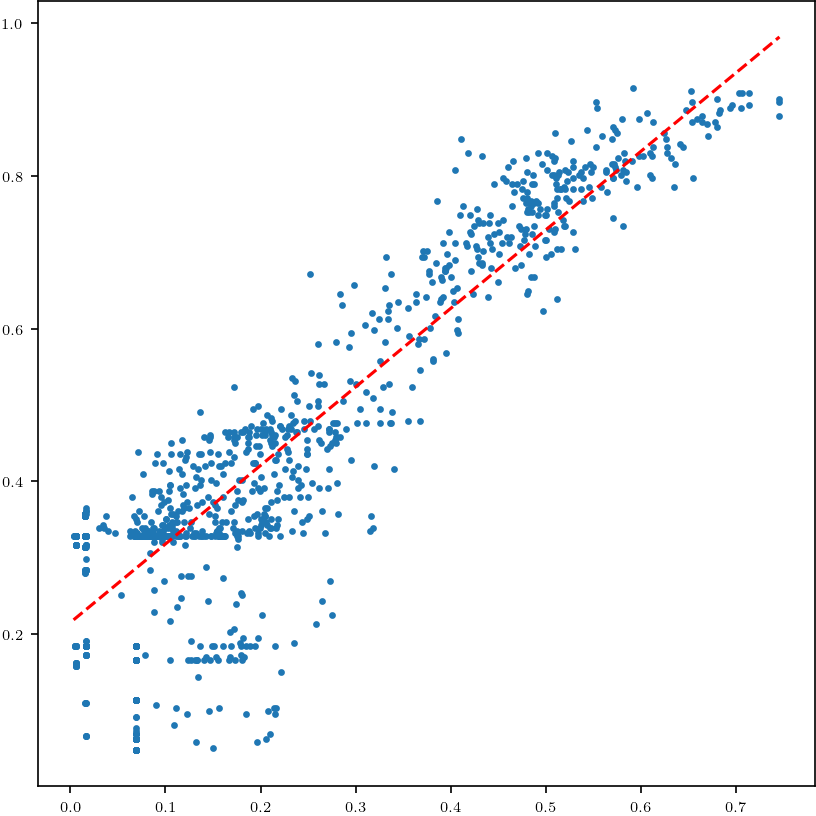

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
from tueplots import bundles
from tueplots import figsizes

df = pd.DataFrame(points)


N_ROWS = 1
N_COLS = 1
RATIO = 1

plt.rcParams.update(bundles.iclr2023(usetex=True))
plt.rcParams.update(figsizes.iclr2023(ncols=N_COLS, nrows=N_ROWS, height_to_width_ratio=RATIO))


fig, ax1 = plt.subplots(nrows=N_ROWS, ncols=N_COLS, dpi=150)
ax1.scatter(df.similarity, df.score, s=5)

z = np.polyfit(df.similarity, df.score, 1)
trend_line = np.poly1d(z)
ax1.plot(np.asarray(sorted(df.similarity)) , trend_line(sorted(df.similarity)), 'r--')

ax1.set_aspect('auto')

# ax1.set_xlabel('Similarity')
# ax1.set_xlabel('Similarity')
# ax1.set_ylabel('Score')


In [42]:
fig.savefig("score_vs_distance.svg", bbox_inches="tight", pad_inches=0)
!rsvg-convert -f pdf -o score_vs_distance.pdf score_vs_distance.svg
!rm score_vs_distance.svg

In [43]:
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Correlation over time

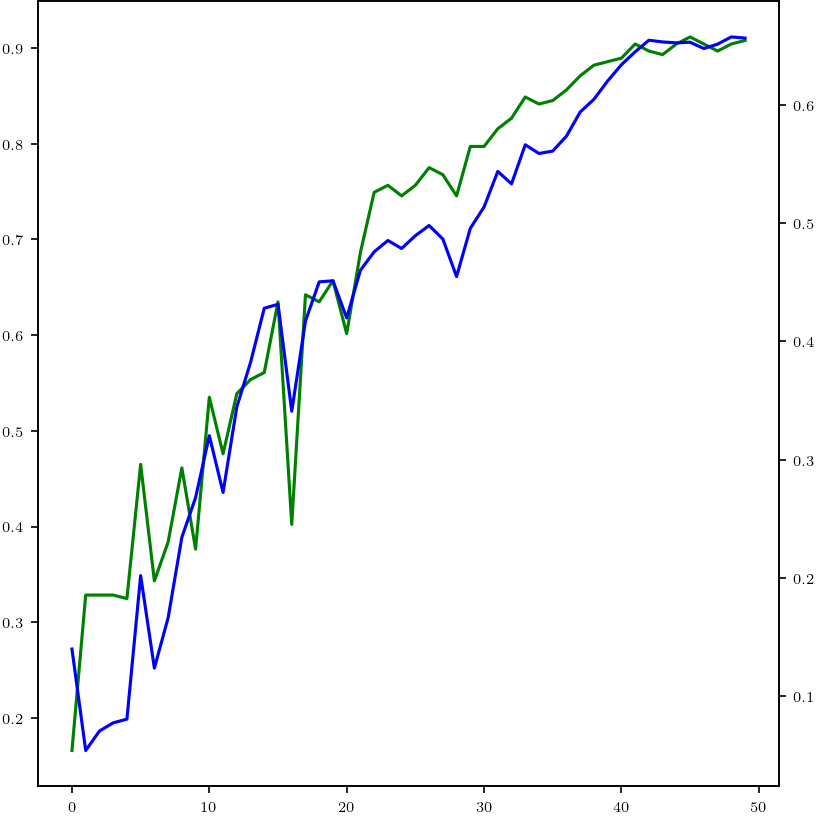

In [44]:
from pytorch_lightning import seed_everything
import random


# Filter experiments that reach at least 0.7 acc.
VAL_ACC_LOWER_BOUND = 0.9

df_max_acc = stats.groupby(['experiment']).agg([np.max])['val_acc']
best_experiments = df_max_acc.loc[df_max_acc['amax'] > VAL_ACC_LOWER_BOUND]
best_experiments = best_experiments.reset_index().experiment
df = stats[stats['experiment'].isin(best_experiments)]
available_experiments = sorted(set(df.experiment))



N_ROWS = 1
N_COLS = 1
RATIO = 1

plt.rcParams.update(bundles.iclr2023(usetex=True))
plt.rcParams.update(figsizes.iclr2023(ncols=N_COLS, nrows=N_ROWS, height_to_width_ratio=RATIO))



def plot_score_dist_over_time(ax, df):

    ax2 = ax.twinx()
    ax.plot(df.epoch, df.val_acc, 'g-')
    ax2.plot(df.epoch, df.reference_distance, 'b-')

#     ax.set_ylabel('Validation Accuracy', color='g')
#     ax2.set_ylabel('Reference similarity', color='b')
#     ax.set_xlabel('epochs')
    

fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, dpi=150)
df_plot = df.loc[df['experiment']==available_experiments[5]]
axes.set_aspect('auto')
plot_score_dist_over_time(axes, df_plot)



In [45]:
fig.savefig("correlation_over_time.svg", bbox_inches="tight", pad_inches=0)
!rsvg-convert -f pdf -o correlation_over_time.pdf correlation_over_time.svg
!rm correlation_over_time.svg

# Correlation grid (supmat)

In [46]:
# Filter experiments that reach at least 0.7 acc.
VAL_ACC_LOWER_BOUND = 0.5

df_max_acc = stats.groupby(['experiment']).agg([np.max])['val_acc']
best_experiments = df_max_acc.loc[df_max_acc['amax'] > VAL_ACC_LOWER_BOUND]
best_experiments = best_experiments.reset_index().experiment
df = stats[stats['experiment'].isin(best_experiments)]
available_experiments = sorted(set(df.experiment))
df

,experiment,epoch,loss,train_acc,val_acc,reference_distance
200,20,0,1.958628,0.153057,0.166052,0.071359
201,20,1,1.906447,0.299138,0.328413,0.047351
202,20,2,1.869278,0.299138,0.328413,0.072053
203,20,3,1.846171,0.299138,0.328413,0.076419
204,20,4,1.835584,0.299138,0.328413,0.092966
...,...,...,...,...,...,...
50145,1674,45,0.550562,0.877308,0.845018,0.522541
50146,1674,46,0.543610,0.878950,0.856089,0.529945
50147,1674,47,0.529152,0.891260,0.856089,0.540293
50148,1674,48,0.517002,0.896594,0.863469,0.563109


2022-09-21 22:45:38 INFO     Global seed set to 0         ]8;id=105047;file:///opt/conda/envs/rae/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py\pytorch_lightning.utilities.seed]8;;\:]8;id=498708;file:///opt/conda/envs/rae/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py#69\69]8;;\

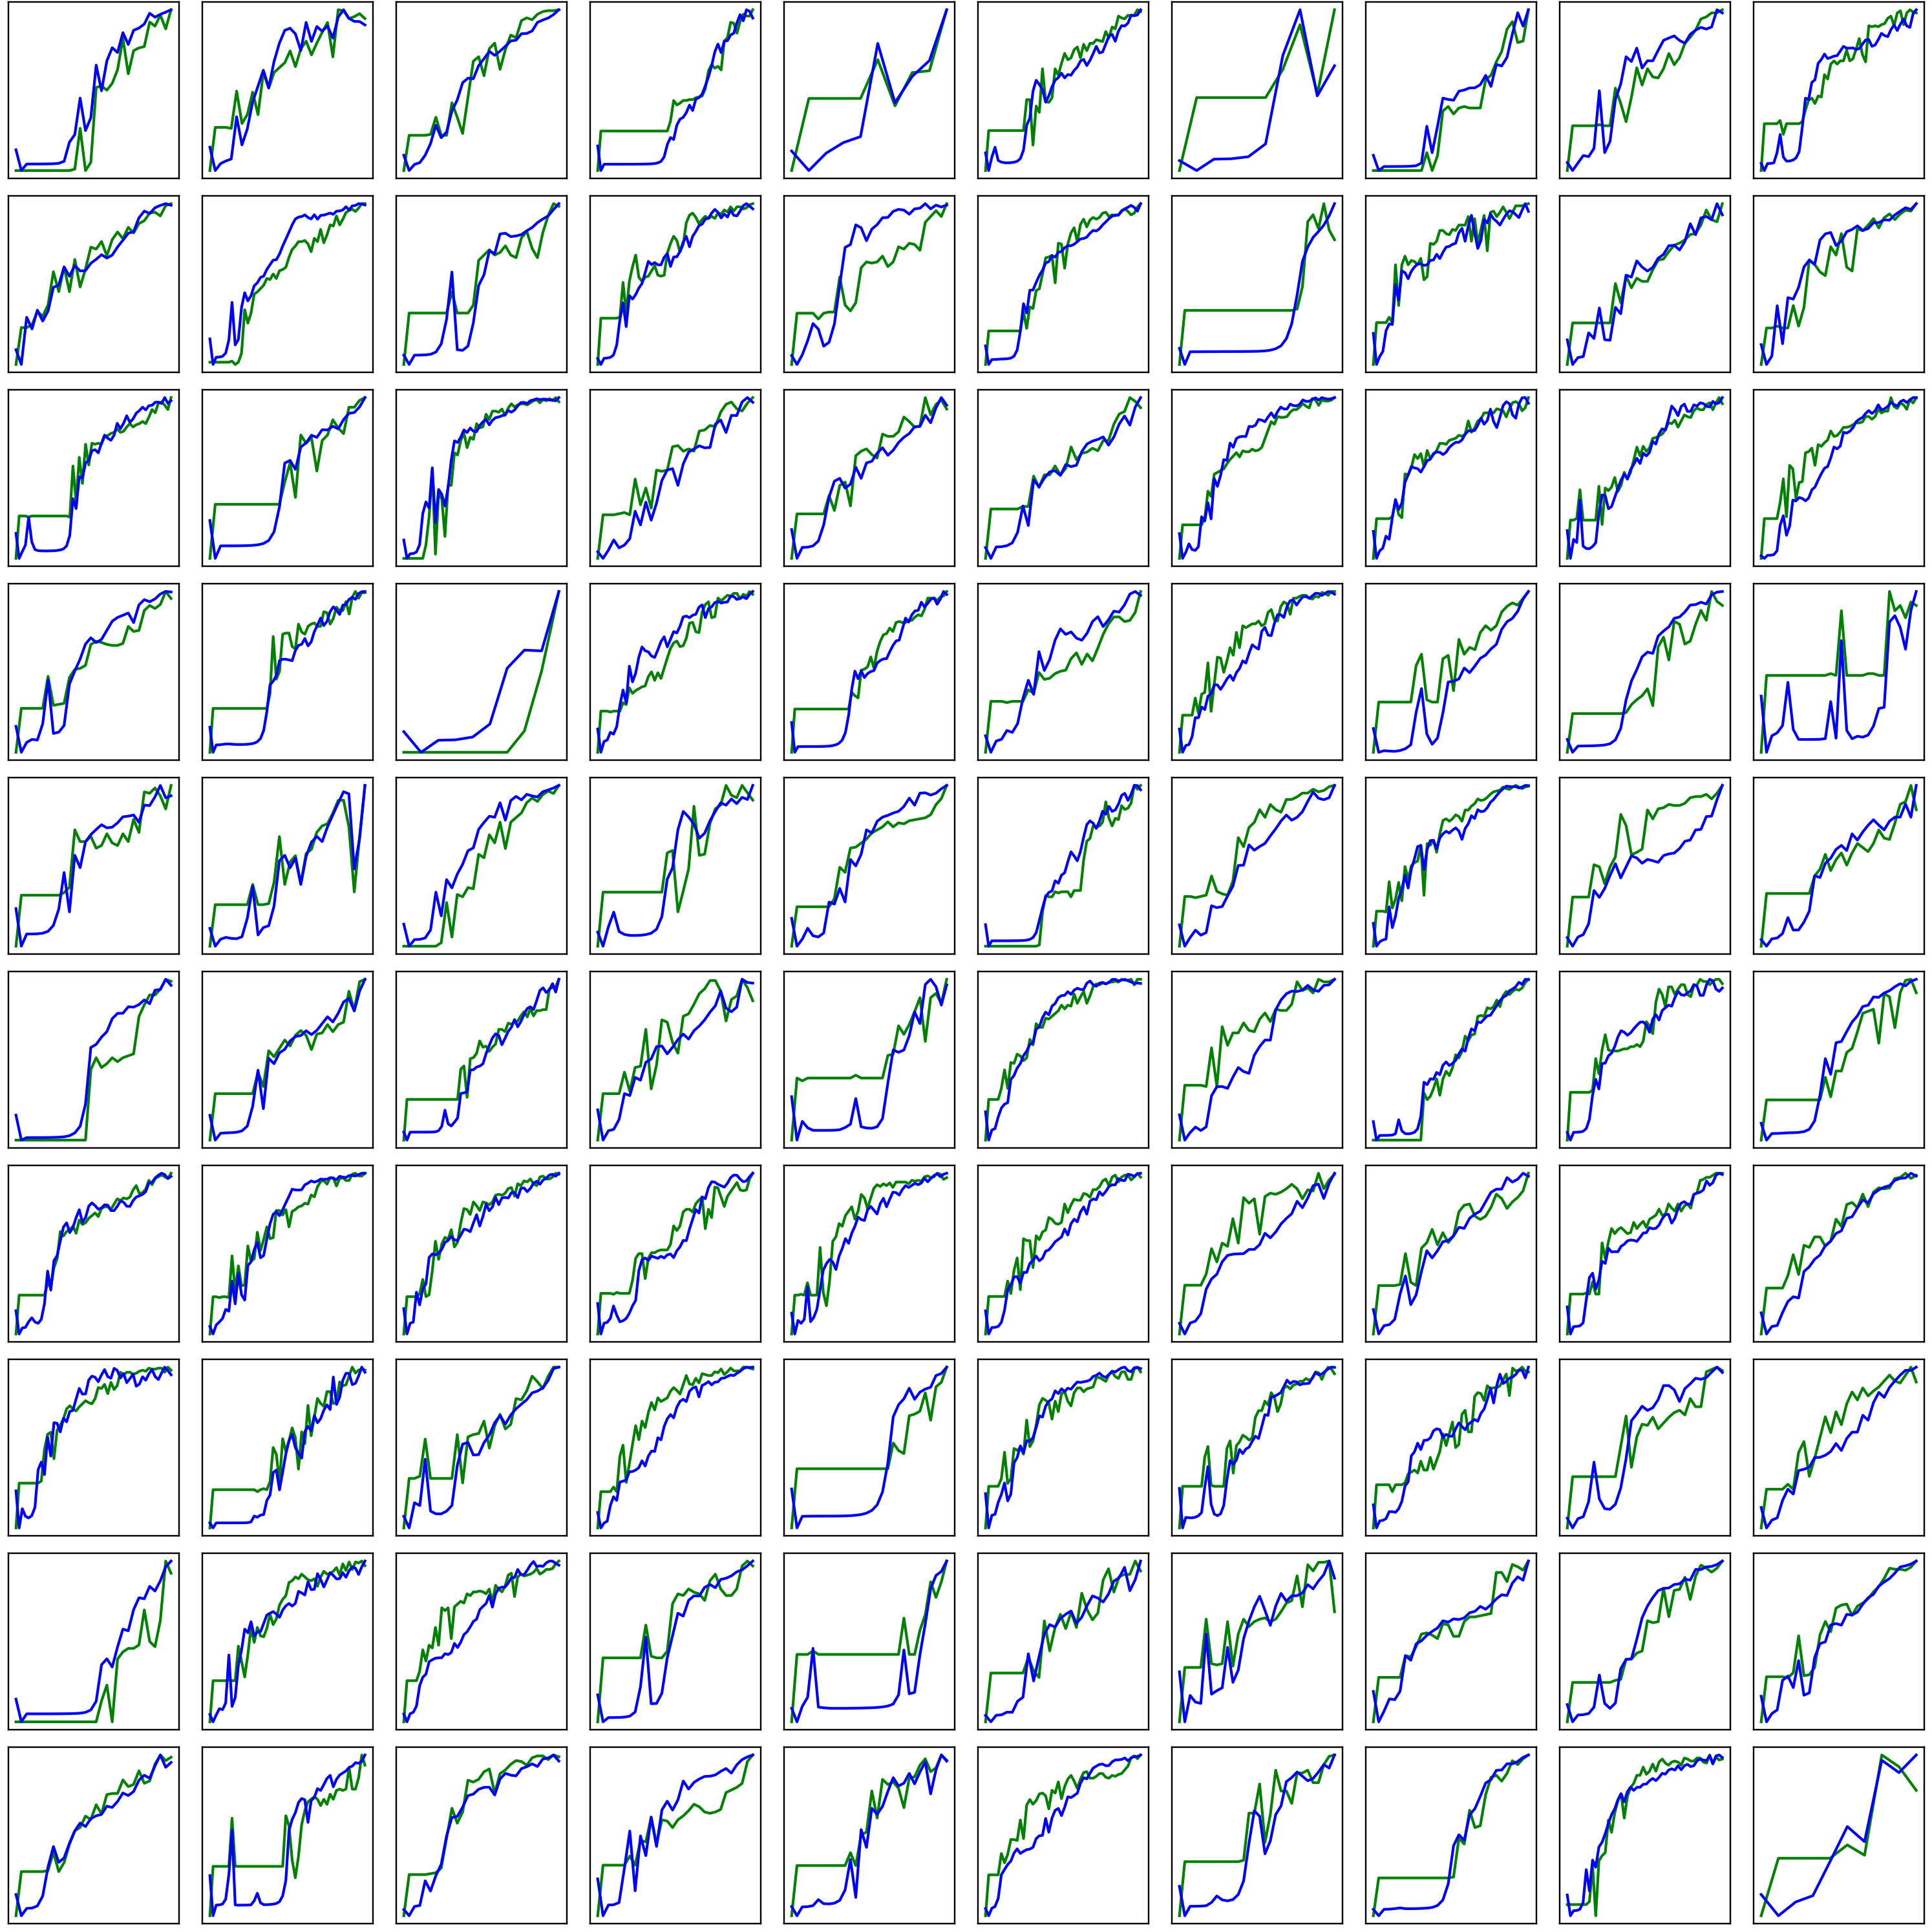

In [49]:
from pytorch_lightning import seed_everything
import random

seed_everything(0)
random.shuffle(available_experiments)

N_ROWS = 10
N_COLS = 10
RATIO = 1

plt.rcParams.update(bundles.iclr2023(usetex=True))
plt.rcParams.update(figsizes.iclr2023(ncols=N_COLS, nrows=N_ROWS, height_to_width_ratio=RATIO))


fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, dpi=200, figsize=(15, 15))

def plot_score_dist_over_time(ax, df):
    ax2 = ax.twinx()
    ax.plot(df.epoch, df.val_acc, 'g-')
    ax2.plot(df.epoch, df.reference_distance, 'b-')
    ax.set_yticklabels([])
    ax2.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax2.set_yticks([])
    ax.set_aspect('auto')

    
i = 0
for row in axes:
    for ax in row:
        df_plot = df.loc[df['experiment']==available_experiments[i]]
        plot_score_dist_over_time(ax, df_plot)
        i += 1


In [50]:
fig.savefig("correlation_grid.svg", bbox_inches="tight", pad_inches=0)
!rsvg-convert -f pdf -o correlation_grid.pdf correlation_grid.svg
!rm correlation_grid.svg